# ADS 509 Sentiment Assignment

This notebook holds the Sentiment Assignment for Module 6 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In a previous assignment you put together Twitter data and lyrics data on two artists. In this assignment we apply sentiment analysis to those data sets. If, for some reason, you did not complete that previous assignment, data to use for this assignment can be found in the assignment materials section of Blackboard. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [2]:
import os
import re
import emoji
import pandas as pd
import numpy as np

from collections import Counter, defaultdict
from string import punctuation

from nltk.corpus import stopwords

sw = stopwords.words("english")

In [40]:
# Add any additional import statements you need here
import csv
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
import string
import matplotlib.pyplot as plt
import emoji

[nltk_data] Downloading package vader_lexicon to C:\Users\Luis
[nltk_data]     Perez\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [4]:
# change `data_location` to the location of the folder on your machine.
data_location = "Users/Luis Perez/Documents/"


# These subfolders should still work if you correctly stored the 
# data from the Module 1 assignment
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

positive_words_file = "positive-words.txt"
negative_words_file = "negative-words.txt"
tidy_text_file = "tidytext_sentiments.txt"

## Data Input

Now read in each of the corpora. For the lyrics data, it may be convenient to store the entire contents of the file to make it easier to inspect the titles individually, as you'll do in the last part of the assignment. In the solution, I stored the lyrics data in a dictionary with two dimensions of keys: artist and song. The value was the file contents. A Pandas data frame would work equally well. 

For the Twitter data, we only need the description field for this assignment. Feel free all the descriptions read it into a data structure. In the solution, I stored the descriptions as a dictionary of lists, with the key being the artist. 




In [5]:
# Read in the lyrics data

lyrics = {}

# Define the artist names and file paths
artists = {
    'cher': '/Users/Luis Perez/Documents/lyrics/cher',
    'robyn': '/Users/Luis Perez/Documents/lyrics/robyn'
}

for artist_name, artist_path in artists.items():
    artist_lyrics = {}
    # loop over files on artist folder
    for file in os.listdir(artist_path):
        #  if lyrics file ends with .txt
        if file.endswith(".txt"):
            song_name = file.split("_")[-1].split(".")[0]
            with open(os.path.join(artist_path, file), 'r') as f:
                artist_lyrics[song_name] = f.read()
    
    lyrics[artist_name] = artist_lyrics
   

In [6]:
# Read in the twitter data
artists = {
    'cher': [],
    'robyn': [],
}
for file in os.listdir("/Users/Luis Perez/Documents/twitter"):
    # first part of checking .txt file
    if file.endswith("robynkonichiwa_follower_data.txt"):
        with open(os.path.join("/Users/Luis Perez/Documents/twitter", file), 'r', encoding="utf-8") as f:
            csvFile = csv.DictReader(f, delimiter='\t')
            for row in csvFile:
                if 'description' in row:
                    artists['robyn'].append(row['description'])
    # second part of checking .txt filer cher
    elif file.endswith("cher_follower_data.txt"):
        with open(os.path.join("/Users/Luis Perez/Documents/twitter", file), 'r', encoding="utf-8") as f:
            csvFile = csv.DictReader(f, delimiter='\t')
            for row in csvFile:
                if 'description' in row:
                    artists['cher'].append(row['description'])

In [261]:
# Read in the positive and negative words and the
# tidytext sentiment. Store these so that the positive
# words are associated with a score of +1 and negative words
# are associated with a score of -1. You can use a dataframe or a 
# dictionary for this.

# Load the positive and negative words
with open('positive-words.txt', 'r') as f:
    for line in f:
        if ';' in line:
            continue
        positive_words = [line.strip() for line in f.readlines()]

with open('negative-words.txt', 'r') as f:
     for line in f:
        if ';' in line:
            continue
        negative_words = [line.strip() for line in f.readlines()]
   
    
text_sentiments = pd.read_csv('tidytext_sentiments.txt', sep='\t')
    
# Create dictionary of words and sentiment scores
sentimentScores = {}
for word in positive_words:
    sentimentScores[word] = 1
for word in negative_words:
    sentimentScores[word] = -1

# Create DataFrame from dictionary
df_sentiment = pd.DataFrame.from_dict(sentimentScores, orient='index', columns=['Sentiment Score'])
df_sentiment.index.name = 'word'


In [262]:
df_sentiment.head()

,Sentiment Score
word,
a+,1
abound,1
abounds,1
abundance,1
abundant,1


## Sentiment Analysis on Songs

In this section, score the sentiment for all the songs for both artists in your data set. Score the sentiment by manually calculating the sentiment using the combined lexicons provided in this repository. 

After you have calculated these sentiments, answer the questions at the end of this section.


In [9]:
def lyrics_clean_and_tokenize(text):
    
    # Remove punctuation characters
    text = text.translate(str.maketrans("", "", string.punctuation))
    
    #split on whitespace
    tokens= text.split()
    
    
    # Convert the text to lowercase
    text = text.lower()
    
    #remove stopwords 
    stop_words = set(stopwords.words('english'))
    rm_stopwords= [token for token in tokens if token not in stop_words]
    
    return rm_stopwords 

cleaned_lyrics= {}
cleaned_lyrics2= {}

for artist, artist_lyrics in lyrics.items():
    cleaned_lyrics[artist] = {}
    for song,song_lyrics in artist_lyrics.items():
        if song_lyrics:  # check if lyrics is not empty
            cleaned_lyrics[artist][song]= lyrics_clean_and_tokenize(song_lyrics)
            cleaned_lyrics2[song]= lyrics_clean_and_tokenize(song_lyrics)

In [281]:
def sentiment(tokens, positive_words, negative_words, text_sentiments):
    p_count = sum([1 for token in tokens if token in positive_words])
    n_count = sum([1 for token in tokens if token in negative_words])
    sentiment_score = p_count - n_count
    for token_sentiment in text_sentiments:
        if token_sentiment == "positive":
            sentiment_score += 1
        elif token_sentiment == "negative":
            sentiment_score -= 1
    return sentiment_score

# Loop over the songs for both artists
a = []
for artist in cleaned_lyrics:
    for song in cleaned_lyrics[artist]:
        # Calculate the sentiment score for the song
        song_score = sentiment(cleaned_lyrics[artist][song], positive_words, negative_words, text_sentiments)
        a.append([artist,song,song_score])
        

df_songScore = pd.DataFrame(a, columns=['artist', 'song', 'score'])




In [282]:
print(df_songScore.head())

  artist                      song  score
0   cher                 88degrees      5
1   cher  adifferentkindoflovesong     14
2   cher                  afterall     -2
3   cher                     again      1
4   cher                     alfie      7


In [13]:
#Q: Overall, which artist has the higher average sentiment per song? 
avg_sentiment = df_songScore.groupby(['artist']).mean()
avg_sentiment

,score
artist,
cher,2.373418
robyn,1.355769


In [286]:
#For your first artist, what are the three songs that have the highest and lowest sentiments?

cher=df_songScore[df_songScore['artist']=='cher']

cher_hs = cher.sort_values(by='score', ascending=False)[:3]
cher_ls = cher.sort_values(by='score', ascending=True)[:3]

print(f"highest sentiment: \n{cher_hs}")
print('\n\n')
print(f"lowest sentiment: \n{cher_ls}")



highest sentiment: 
    artist                  song  score
198   cher            perfection     46
181   cher                mylove     44
155   cher  loveandunderstanding     38



lowest sentiment: 
    artist                     song  score
133   cher  iwalkonguildedsplinters    -26
196   cher               outrageous    -20
139   cher                    julie    -18


In [15]:
#Print the lyrics of those songs to the screen.
#What do you think is driving the sentiment score
print("Top 3 songs with the highest sentiments\n")
print("perfection :",lyrics['cher']['perfection'].replace('\n', ''),"\n")
print("my love :",lyrics['cher']['mylove'].replace('\n', ''),"\n")
print("love and understanding :",lyrics['cher']['loveandunderstanding'].replace('\n', ''))


Top 3 songs with the highest sentiments

perfection : "Perfection"Hush little Baby, gotta be strong'Cause in this world we are born to fightBe the best, prove them wrongA winner's work is never done, reach the top, number oneOh, perfectionYou drive me crazy with perfectionI've worn my pride as my protectionPerfection, ohhI was taught to be toughThat the best that you can be ain't enoughCrack the whip, sacrificeBut I found out paradise had a priceI didn't know it then, but oh I know it nowYou gotta work as hard as love to make the love work outYou know this heart of mine has made some big mistakesI guess that when it comes to love, I just don't know what I takesAll my life I've been driven by perfectionPushed it to the limit every day and nightOhh, I've been driven by perfectionBut nothing's perfect when love ain't rightNothing's perfect when the love ain't rightGave it all, played my partI gave everything I had but my heartWorked so hard, made a nameBut the loneliness inside stays the 

In [16]:
#Print the lyrics of those songs to the screen.
#What do you think is driving the sentiment score
print("Top 3 songs with the lowest sentiments\n")
print("I walk on guilded splinters :",lyrics['cher']['iwalkonguildedsplinters'].replace('\n', ''),"\n")
print("outrageous :",lyrics['cher']['outrageous'].replace('\n', ''),"\n")
print("julie :",lyrics['cher']['julie'].replace('\n', ''))


Top 3 songs with the lowest sentiments

I walk on guilded splinters : "I Walk On Guilded Splinters"Some people think they jive me, but I know they must be crazyThey can't see their misfortune, or else they're just too lazyJe suie le grand zombieWith my yellow chaffen of choisenAin't afraid of no tomcat and gonna fill my guts with poisonI walk through the fireAnd I'll fly through the smokeI wanna see my enemiesOn the end of my ropeWalk on pins and needlesAnd I see what they can doWalk on guilded splintersWith the King of the ZuluCome to me, get it, come, comeWalk on guilded splintersCome to me, get it, come, comeWalk on guilded splintersTill I burn upTill I burn upTill I burn upTill I burn upWhen I roll out in my coffinDrink poison in my chalicePride begins to fadeAnd you all feel my maliceI put gris-gris on your doorstepSo soon you be in the gutterI'll make your heart melt like butterI say I can make you stutterCome to me, get it, come, comeWalk on guilded splintersCome to me, get it, 

In [17]:
#For your second artist, what are the three songs that have the highest and lowest sentiments?

robyn=df_songScore[df_songScore['artist']=='robyn']

robyn_hs = robyn.sort_values(by='score', ascending=False)[:3]
robyn_ls = robyn.sort_values(by='score', ascending=True)[:3]

print(robyn_hs)
print('\n\n')
print(robyn_ls)


    artist                           song  score
380  robyn                     loveisfree     67
367  robyn                 indestructible     27
368  robyn  indestructibleacousticversion     23



    artist                             song  score
343  robyn  dontfuckingtellmewhattodo114520    -78
342  robyn        dontfuckingtellmewhattodo    -78
334  robyn                   criminalintent    -46


In [18]:
#Print the lyrics of those songs to the screen.
#What do you think is driving the sentiment score
print("Top 3 songs with the highest sentiments\n")
print("love is free :",lyrics['robyn']['loveisfree'].replace('\n', ''),"\n")
print("indestructible :",lyrics['robyn']['indestructible'].replace('\n', ''),"\n")
print("indestructible acoustic version :",lyrics['robyn']['indestructibleacousticversion'].replace('\n', ''))

Top 3 songs with the highest sentiments

love is free : "Love Is Free"FreeLove is free, babyFreeLove is free, babyBoom boom boom boom boom chica boomLet me give it to you, babyChica boom chica boom chica boomChica boom chica boom chica boomFreeLove is free, babyFreeLove is free, babyBoom boom boom boom boom chica boomLet me give it to you, babyI'ma give it to you, babyI'ma give it when I'm readySome lose, some steadySome light, some heavyIt's all over this citySometimes in the ugly, sometimes in the prettyYou never know where you get it cause you can't control it and you can't unfold it, slow downI'ma give it to you, babyI'ma give it when I'm readySome lose, some steadySome light, some heavyIt's all over this citySometimes in the ugly, sometimes in the prettyYou never know where you get it cause you can't control it and you can't unfold it, slow downFreeLove is free, babyFreeLove is free, babyBoom boom boom boom boom chica boomLet me give it to you, babyYeah! Yeah! Yeah! Yeah!Love is f

In [19]:
#Print the lyrics of those songs to the screen.
#What do you think is driving the sentiment score
print("Top 3 songs with the highest sentiments\n")
print("dont fucking tell me what to do 114520 :",lyrics['robyn']['dontfuckingtellmewhattodo114520'].replace('\n', ''),"\n")
print("dont fucking tell me what to do :",lyrics['robyn']['dontfuckingtellmewhattodo'].replace('\n', ''),"\n")
print("criminal intent :",lyrics['robyn']['criminalintent'].replace('\n', ''))

Top 3 songs with the highest sentiments

dont fucking tell me what to do 114520 : "Don't Fucking Tell Me What To Do"My drinking is killing meMy drinking is killing meMy drinking is killing meMy drinking is killing meMy drinking is killing meMy drinking is killing meMy drinking is killing meMy drinking is killing meMy drinking is killing meMy drinking is killing meMy drinking is killing meMy drinking is killing meMy drinking is killing meMy drinking is killing meMy drinking is killing meMy smoking is killing meMy diet is killing meMy heels are killing meMy shopping's killing meMy ego is killing meCan't sleep, it's killing meMy label's killing meKickdrumMy phone is killing meMy email is killing meThese hours are killing meMy tour is killing meThis flight is killing meMy manager's killing meMy mother's killing meMy landlord's killing meMy boss is killing meThe TV is killing meYour nagging is killing meMy boyfriend's killing meMy talking's killing meKilling meKilling meCan't sleep, it's ki

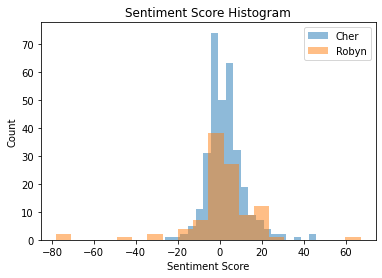

In [20]:
# Plot the distributions of the sentiment scores for both artists.
#You can use `seaborn` to plot densities or plot histograms in matplotlib.
plt.hist(cher['score'], bins=20, alpha=0.5, label='Cher')
plt.hist(robyn['score'], bins=20, alpha=0.5, label='Robyn')
plt.title('Sentiment Score Histogram')
plt.xlabel('Sentiment Score')
plt.ylabel('Count')
plt.legend()
plt.show()

### Questions

Q: Overall, which artist has the higher average sentiment per song? 

A: Cher has the higher sentiment scores per song (2.37) compared to Robyn at (1.35). 

---

Q: For your first artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score? 

A: I believe that based on the lyrics the songs talk about love, determination and have high counts of words that we compared to positive words. While the songs that rank low their lyrics had more themes of struggle, loss, and relationship endings.  

highest sentiment: perfection,  mylove, love and understanding

lowest sentiment: iwalkonguildedsplinters, outrageous, julie


---

Q: For your second artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score? 

For Robyn the highest sentiment songs themes and lyrics show celebration, self-empowerment, and love. While the lowest sentiment scoring songs included words like crime, conspiracy, and killing. Its worth nothing that robyn had two versions of the same song. 

higherst sentiment: loveisfree, indestructible, indestructibleacousticversion

lowest sentiment:
dont fucking tell me what to do114520, criminal intent, and dont fucking tell me what to do


   
---

Q: Plot the distributions of the sentiment scores for both artists. You can use `seaborn` to plot densities or plot histograms in matplotlib.




## Sentiment Analysis on Twitter Descriptions

In this section, define two sets of emojis you designate as positive and negative. Make sure to have at least 10 emojis per set. You can learn about the most popular emojis on Twitter at [the emojitracker](https://emojitracker.com/). 

Associate your positive emojis with a score of +1, negative with -1. Score the average sentiment of your two artists based on the Twitter descriptions of their followers. The average sentiment can just be the total score divided by number of followers. You do not need to calculate sentiment on non-emoji content for this section.

In [21]:
def twitter_clean_and_tokenize(text):
    
    #punctuation characters except #'s'
    text_without_hash = string.punctuation.replace("#", "")
    trans_table = str.maketrans("", "", text_without_hash)

    #remove punctuation
    text = text.translate(trans_table)
    
    #split on whitespace
    tokens= text.split()
    
    
    # Convert the text to lowercase
    text = text.lower()
    
    #remove stopwords 
    stop_words = set(stopwords.words('english'))
    rm_stopwords= [token for token in tokens if token not in stop_words]
    
    return rm_stopwords 

# Iterate over the artists and their descriptions
for artist, descriptions in artists.items():
    cleaned_descriptions = []
    for description in descriptions:
        if description:  # check if empty
            cleaned_descriptions.append(twitter_clean_and_tokenize(description))
    artists[artist] = cleaned_descriptions

In [224]:
# your code here
# Load the positive and negative words
with open('pos_emoji.txt', 'r',encoding='utf-8') as f:
        positive_emoji = [line.strip() for line in f.readlines()]

with open('neg_emoji.txt', 'r',encoding='utf-8') as f:
    negative_emoji = [line.strip() for line in f.readlines()]





In [225]:
def sentiment(tokens, positive_emoji, negative_emoji):
    p_count = sum([1 for token in tokens if token in positive_emoji])
    n_count = sum([1 for token in tokens if token in negative_emoji])
    return p_count, n_count



In [110]:
# Loop over the describtions for both artists
al = []
for artist in artists:
    for desc in artists[artist]:
        desc_score = sentiment(desc, positive_emoji, negative_emoji)
        #capture emoji
        emojis = []
        for char in desc:
            if emoji.is_emoji(char):
                emojis.append(char)
        al.append([artist,emojis,desc_score])


In [228]:
emoji_count_by_artist = {}
for item in al:
    artist = item[0]
    emojis = item[1]
    desc_score = item[2]
    if artist not in emoji_count_by_artist:
        emoji_count_by_artist[artist] = {}
    for emoji in emojis:
        if emoji in emoji_count_by_artist[artist]:
            emoji_count_by_artist[artist][emoji] += 1
        else:
            emoji_count_by_artist[artist][emoji] = 1
for artist in emoji_count_by_artist:
    sorted_emojis = sorted(emoji_count_by_artist[artist].items(), key=lambda x: x[1], reverse=True)
    emoji_count_by_artist[artist] = sorted_emojis
for artist in emoji_count_by_artist:
    print(f"Top 10 emojis used by {artist}:")
    for i in range(min(10, len(emoji_count_by_artist[artist]))):
        emoji = emoji_count_by_artist[artist][i][0]
        count = emoji_count_by_artist[artist][i][1]
        print(f"{emoji}: {count}")



Top 10 emojis used by cher:
🏳️‍🌈: 270
❤️: 230
✨: 147
💙: 111
🇺🇸: 110
❤: 104
🌈: 84
💜: 70
🇺🇦: 64
🖤: 62
Top 10 emojis used by robyn:
🏳️‍🌈: 797
✨: 267
🌈: 255
❤️: 225
🎶: 96
💜: 89
❤: 80
🎧: 75
🖤: 71
🇺🇸: 70


In [196]:
robyn_emoji=artists_emoji_sent[artists_emoji_sent['Artist']=='robyn']
count_r=robyn_emoji.shape[0]
count_r

34385

In [116]:
#number of follower desriptions for cher
cher_emoji=artists_emoji_sent[artists_emoji_sent['Artist']=='cher']
count_c=cher_emoji.shape[0]


#number of follower desriptions for robyn
robyn_emoji=artists_emoji_sent[artists_emoji_sent['Artist']=='robyn']
count_r=robyn_emoji.shape[0]

#You do not need to calculate sentiment on non-emoji content for this section.
cher_emoji_total= cher_emoji['Score'].sum()
cher_emoji_total

robyn_emoji_total= robyn_emoji['Score'].sum()
robyn_emoji_total

#The average sentiment can just be the total score divided by number of followers.
cher_sentiment= cher_emoji_total/count_c
robyn_sentiment= robyn_emoji_total/count_r

print(f"Cher's follower description emoji sentiment: {cher_sentiment}")
print(f"Robyn's follower description emoji sentiment: {robyn_sentiment}")

Cher's follower description emoji sentiment: 0.03442654028436019
Robyn's follower description emoji sentiment: 0.03341573360476952


In [240]:
#Which positive emoji is the most popular for each artist? Which negative emoji?
emoji_counts = {}

# Loop through each artist in emoji_count_by_artist and update emoji_counts
for artist, emoji_list in emoji_count_by_artist.items():
    if artist not in emoji_counts:
        emoji_counts[artist] = {'positive': {}, 'negative': {}}
    
    for emoji, count in emoji_list:
        if emoji in positive_emoji:
            emoji_counts[artist]['positive'][emoji] = count
        elif emoji in negative_emoji:
            emoji_counts[artist]['negative'][emoji] = count
    
    # Find the most common positive and negative emojis for this artist
    pos_emoji = max(emoji_counts[artist]['positive'], key=emoji_counts[artist]['positive'].get)
    neg_emoji = max(emoji_counts[artist]['negative'], key=emoji_counts[artist]['negative'].get)
    
    print(f"{artist}: Most positive emoji - {pos_emoji}, Most negative emoji - {neg_emoji}")



cher: Most positive emoji - ❤️, Most negative emoji - 🙄
robyn: Most positive emoji - ✨, Most negative emoji - 🤡


In [238]:
emoji_counts

{'cher': {'positive': {'❤️': 230,
   '✨': 147,
   '💙': 111,
   '❤': 104,
   '🌈': 84,
   '💜': 70,
   '🎶': 59,
   '😊': 43,
   '😂': 22},
  'negative': {'🙄': 12,
   '🤡': 5,
   '🤬': 4,
   '😢': 3,
   '😕': 3,
   '😒': 3,
   '😱': 2,
   '☹️': 1,
   '😟': 1,
   '🤢': 1,
   '😥': 1,
   '🚩': 1,
   '😮': 1}},
 'robyn': {'positive': {'✨': 267,
   '🌈': 255,
   '❤️': 225,
   '🎶': 96,
   '💜': 89,
   '❤': 80,
   '💙': 60,
   '😊': 23,
   '😂': 15,
   '🏳': 1},
  'negative': {'🤡': 11,
   '🚩': 8,
   '🙄': 5,
   '😒': 3,
   '🤬': 2,
   '😮': 2,
   '😱': 2,
   '😢': 2,
   '😟': 1,
   '😕': 1,
   '☹️': 1}}}

Q: What is the average sentiment of your two artists? 

Cher's follower description emoji sentiment: 0.03442654028436019

Robyn's follower description emoji sentiment: 0.03341573360476952

---

Q: Which positive emoji is the most popular for each artist? Which negative emoji? 

A: cher: Most positive emoji - ❤️, Most negative emoji - 🙄

robyn: Most positive emoji - ✨, Most negative emoji - 🤡

